In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

base_dir = "../input"

print(os.listdir(base_dir))

['y_train.csv', 'sample_submission.csv', 'X_test.csv', 'X_train.csv']


In [14]:
X_train = pd.read_csv(f'{base_dir}/X_train.csv')
y_train = pd.read_csv(f'{base_dir}/y_train.csv')

In [15]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

**Prepare the training data**

In [16]:
series_id_to_surface = {}
surface_to_series_id = {}

for row in y_train.iterrows():
    surface_to_series_id.setdefault(row[1].surface, []).append(row[1].series_id)
    series_id_to_surface[row[1].series_id] = row[1].surface
all_surfaces = list(surface_to_series_id.keys())

n_features = X_train.drop(['row_id', 'series_id', 'measurement_number'], axis=1).shape[1]
n_surfaces = len(all_surfaces)
n_hidden = 128
n_examples = len(X_train['series_id'].unique())
n_sequence = len(X_train['measurement_number'].unique())

In [17]:
import random
from sklearn.model_selection import train_test_split

train_val_split = int(n_examples * 0.9)
dataset_IDs = {}
dataset_IDs['train'], dataset_IDs['eval'] = train_test_split(X_train['series_id'].unique(), test_size=0.05)

In [18]:
print(f'Training size: {len(dataset_IDs["train"])}')
print(f'Validation size: {len(dataset_IDs["eval"])}')

Training size: 3619
Validation size: 191


In [19]:
surface_to_surface_tensor = {}
series_id_to_tensor = {}

for i in range(len(all_surfaces)):
    surface_to_surface_tensor[all_surfaces[i]] = torch.tensor([i], dtype=torch.long).to(device)

def tensor_from_series_id(series_id, df):
    series = df[df['series_id'] == series_id].drop(['row_id', 'series_id', 'measurement_number'], axis=1)
    series_tensor = torch.from_numpy(series.values).view(series.shape[0], 1, -1).float().to(device)
    return series_tensor
    
for series_id in X_train['series_id'].unique():
    series_id_to_tensor[series_id] = tensor_from_series_id(series_id, X_train)
    
def random_training_example(phase):
    series_id = random.choice(dataset_IDs[phase])
    surface = series_id_to_surface[series_id]
    surface_tensor = surface_to_surface_tensor[surface]
    series_tensor = series_id_to_tensor[series_id]
    return series_id, surface, series_tensor, surface_tensor

In [20]:
dataset_targets = {}
dataset_targets['train'] = [series_id_to_surface[series_id] for series_id in dataset_IDs['train']]
dataset_targets['eval'] = [series_id_to_surface[series_id] for series_id in dataset_IDs['eval']]

In [21]:
class LSTMSurface(nn.Module):
    def __init__(self, series_dim, hidden_dim, surface_dim):
        super(LSTMSurface, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(series_dim, hidden_dim, num_layers=2, dropout=0.2)
        self.hidden2surface = nn.Linear(hidden_dim, surface_dim)

    def forward(self, series):
        lstm_out, _ = self.lstm(series)
        surface_space = self.hidden2surface(lstm_out)
        surface_scores = F.log_softmax(surface_space, dim=2)
        return surface_scores[-1]

In [22]:
def surface_from_output(output):
    top_n, top_i = output.topk(1)
    surface_i = top_i[0].item()
    return all_surfaces[surface_i], surface_i

In [23]:
model = LSTMSurface(n_features, n_hidden, n_surfaces).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

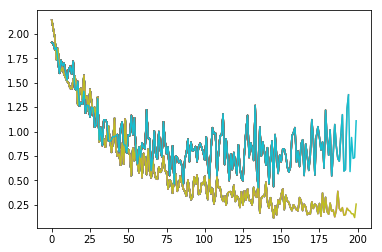

In [24]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statistics
import copy

n_epochs = 200000
save_loss_every = 10
print_every = 1000
plot_every = 5000
losses = {'train': [], 'eval': []}
accs = {'train': [], 'eval': []}

all_losses = {'train': [], 'eval': []}

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
        
fig = plt.figure()

for epoch in range(1, n_epochs + 1):
    for phase in ['train', 'eval']:
        optimizer.zero_grad()

        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        _, _, inputs, targets = random_training_example(phase)
        
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, preds = torch.max(outputs, 1)

            if phase == 'train':
                loss.backward()
                optimizer.step()
        
        if epoch % save_loss_every == 0:
            running_loss = loss.item() * inputs.size(1)
            running_corrects = torch.sum(preds == targets.data)
            epoch_loss = running_loss / len(targets)
            epoch_acc = running_corrects.double() / len(targets)
            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc.item())
        
        if phase == 'eval' and epoch % print_every == 0:
            training_loss = statistics.mean(losses['train'])
            validation_loss = statistics.mean(losses['eval'])
            all_losses['train'].append(training_loss)
            all_losses['eval'].append(validation_loss)
            training_acc = statistics.mean(accs['train'])
            validation_acc = statistics.mean(accs['eval'])
            if validation_acc > best_acc:
                best_acc = validation_acc
                print(f'Best accuracy so far! Acc = {best_acc}')
                best_model_wts = copy.deepcopy(model.state_dict())
            print(f'{epoch} {epoch / n_epochs:.2%} / Train Loss: {training_loss:.4}, Validation Loss: {validation_loss:.4} / Train Accuracy: {training_acc:.2%}, Validation Accuracy: {validation_acc:.2%}')
            losses = {'train': [], 'eval': []}
            accs = {'train': [], 'eval': []}
        
        if phase == 'eval' and epoch % plot_every == 0:
            plt.plot(all_losses['train'], label='Train loss')
            plt.plot(all_losses['eval'], label='Validation loss')
            display.display(plt.gcf())
            display.clear_output(wait=True)

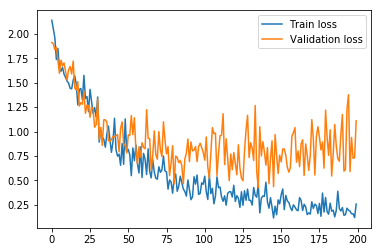

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses['train'], label='Train loss')
plt.plot(all_losses['eval'], label='Validation loss')
plt.legend()

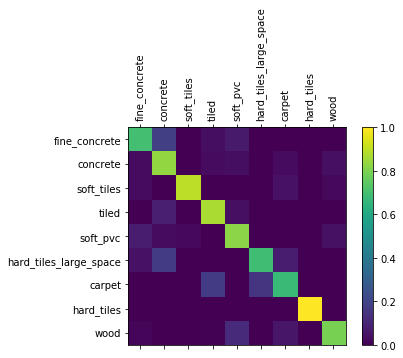

concrete                  249
soft_pvc                  216
wood                      137
tiled                     107
soft_tiles                 96
fine_concrete              91
carpet                     53
hard_tiles_large_space     49
hard_tiles                  2
dtype: int64
Validation accuracy = 81.20%


In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

model.load_state_dict(best_model_wts)

confusion = torch.zeros(n_surfaces, n_surfaces)
n_confusion = 1000

def evaluate(series_tensor):
    with torch.no_grad():
        scores = model(series_tensor)
        return scores

all_guesses = []
hits = 0
for i in range(n_confusion):
    series_id, surface, series_tensor, surface_tensor = random_training_example('eval')
    output = evaluate(series_tensor)
    guess, guess_i = surface_from_output(output)
    all_guesses.append(guess)
    surface_i = all_surfaces.index(surface)
    confusion[surface_i][guess_i] += 1
    if surface_i == guess_i:
        hits += 1

accuracy = hits / n_confusion

for i in range(n_surfaces):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_surfaces, rotation=90)
ax.set_yticklabels([''] + all_surfaces)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
print(pd.Series(all_guesses).value_counts())
print(f'Validation accuracy = {accuracy:.2%}')

In [27]:
X_test = pd.read_csv(f'{base_dir}/X_test.csv')
predictions = []
for series_id in X_test['series_id'].unique():
    series_tensor = tensor_from_series_id(series_id, X_test)
    output = evaluate(series_tensor)
    guess, guess_i = surface_from_output(output)
    predictions.append((series_id, guess))
submission = pd.DataFrame(predictions, columns=['series_id', 'surface'])

In [28]:
print(submission.to_csv(index=False))

series_id,surface
0,hard_tiles_large_space
1,carpet
2,tiled
3,wood
4,soft_tiles
5,concrete
6,fine_concrete
7,tiled
8,wood
9,wood
10,fine_concrete
11,tiled
12,wood
13,soft_pvc
14,fine_concrete
15,tiled
16,wood
17,carpet
18,wood
19,fine_concrete
20,carpet
21,fine_concrete
22,fine_concrete
23,hard_tiles_large_space
24,concrete
25,wood
26,concrete
27,tiled
28,carpet
29,concrete
30,fine_concrete
31,concrete
32,concrete
33,soft_pvc
34,soft_pvc
35,wood
36,carpet
37,soft_tiles
38,wood
39,soft_pvc
40,carpet
41,soft_tiles
42,soft_pvc
43,carpet
44,soft_pvc
45,wood
46,wood
47,carpet
48,wood
49,concrete
50,wood
51,concrete
52,fine_concrete
53,tiled
54,carpet
55,concrete
56,tiled
57,wood
58,wood
59,concrete
60,wood
61,wood
62,tiled
63,concrete
64,concrete
65,soft_pvc
66,concrete
67,concrete
68,soft_pvc
69,hard_tiles_large_space
70,tiled
71,fine_concrete
72,fine_concrete
73,wood
74,fine_concrete
75,wood
76,tiled
77,soft_pvc
78,soft_pvc
79,soft_pvc
80,soft_tiles
81,tiled
82,wood
83,tiled
84,concrete
8

In [29]:
submission.to_csv('lstm_submission_final.csv', index=False)